In [34]:
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import os
from osgeo import gdal
from osgeo import gdalconst
import gloce as gc
import time
from mpl_toolkits.basemap import Basemap
from scipy.stats import gaussian_kde
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
pathin = '/'
pathpic = '/'
fig_title = ['a', 'b', 'c', 'd', 'e', 'f','g']

In [20]:
def nanaverage(data,axis=(0,1),weights=0):
    weights0 = np.copy(weights)
    weights0[np.isnan(data)]=np.nan
    tem1 = np.nansum(data*weights0,axis=axis)
    tem2 = np.nansum(weights0,axis=axis)
    return tem1/tem2
def w_std_1d(array,w=0):
    mean = nanaverage(array,axis=(0),weights = w)
    std0 = np.sqrt(nanaverage((array-mean)**2,axis=(0),weights = w))
    return std0

# Fig.1

In [8]:
smy = np.load(pathin +'smy_lc.npy')
#6,720,1440  1 non-forest +5 forest area: Burned forest, Isolated forest, Edge forest, Other degraded forest, Interior forest
smy = smy[1:6]
# make dominant landcover map
smy_domi = np.zeros((4,720,1440))
smy_domi[:]=np.nan
smy_degraded = smy[:4]
smy_degraded[np.isnan(smy_degraded)]=0
smy_all = np.nansum(smy_degraded,0)
tem = np.argmax(smy_degraded,0)
tem2 = np.max(smy_degraded,0)
tem = tem.astype(np.float)
tem[tem2<0.05]=np.nan
for i in range(4):
    smy_domi[i,tem==i]=smy_degraded[i,tem==i]
smy_forest = np.zeros((720,1440))
smy_forest[:]=np.nan
smy_forest[np.all([tem2<0.05,smy[-1]>0.05],0)]=1
#prepare data for the pie chart
area = gc.globalarea(0.25)
frac0 = np.nansum(smy * area, (1, 2)) / np.sum(np.nansum(smy * area, (1, 2)))
frac_region = np.zeros((3, 5))  #3 regions; 5 fractios
region = np.array([[240, 600], [600, 960], [1000, 1360]])# Tropical America, Africa, Asia
for j in range(3):
    frac_region[j,:] = np.nansum(
        smy[:,266:454, region[j, 0]:region[j, 1]] *
        area[266:454, region[j, 0]:region[j, 1]], (1, 2)) / np.sum(
            np.nansum(
                smy[:,266:454, region[j, 0]:region[j, 1]] *
                area[266:454, region[j, 0]:region[j, 1]], (1, 2)))
frac_all = np.zeros((4,5))
frac_all[3]=frac0
frac_all[:3]=frac_region#colorbar
iso = mpl.colors.LinearSegmentedColormap.from_list('iso', ['#ebeed7','#a6a936'], 100)#  #f2f3e5
burn = mpl.colors.LinearSegmentedColormap.from_list('burn', ['#f2d5cd','#902223'], 100)
edge = mpl.colors.LinearSegmentedColormap.from_list('edge', ['#a9cce3','#154361'], 100)##1a97c7
log = mpl.colors.LinearSegmentedColormap.from_list('log', ['#c39bd2','#4a235a'], 100)
white = mpl.colors.LinearSegmentedColormap.from_list('white', ['#ffffff','#ffffff'], 100)

<ipython-input-8-595475b39067>:11: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tem = tem.astype(np.float)


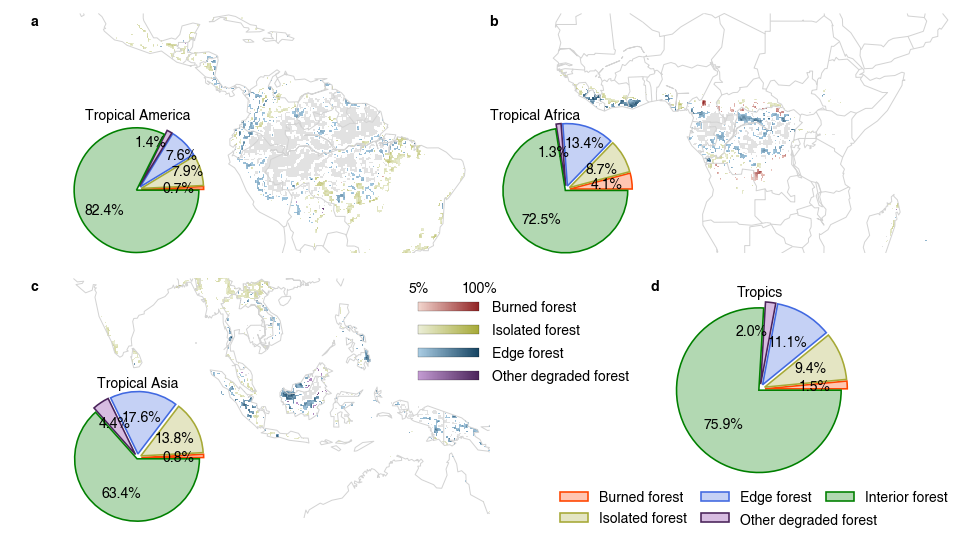

In [10]:
cmap4 = ['burn','iso','edge','log','white']
color = ['#FF4500','#a6a936','#4169E1','#4a235a','#008000']# isolated burned edge other interior
color_30 = ['#ffc6b2','#e4e5c3','#c5d1f5','#d7bce1','#b2d8b2']
lc_1 = [
    'Burned forest', 'Isolated forest', 'Edge forest','Other degraded forest','Interior forest'
]
lc_2 = [
    'Burned forest','Isolated forest',  'Edge forest',' ','Interior forest'
]
lb_region = ['Tropical America','Tropical Africa','Tropical Asia','Tropics']
#---------plot map--------------------------
plt.rcParams['xtick.direction'] = 'out'
cm = 1/2.54
fig = plt.figure(figsize=(18*cm, 11*cm))  ##width, height default(8,6)
font = {
    'family': 'sans-serif',
    'sans-serif': 'Helvetica',
    'weight': 'normal',
    'size': 7
}
plt.rc('font', **font)  # pass in the font dict as kwargs
fig.subplots_adjust(wspace=0,
                    hspace=0,
                    right=0.95,
                    left=0.05,
                    bottom=0.05,
                    top=0.95)
#--------------------------------------------------------------
lw_contry = 0.5
ax = fig.add_axes([0.05, 0.5, 0.9, 0.45])#left, bottom width, height
lon_w=-120;lon_e=60
lat_s=-23.5;lat_n=23.5
c_text = 'black'
ax.set_xticklabels([])
ax.set_yticklabels([])
m = Basemap(llcrnrlon=lon_w,llcrnrlat=lat_s,urcrnrlon=lon_e,urcrnrlat=lat_n)
for i in range(4):
    m.imshow(smy_domi[i,266:454,240:960], origin="upper", alpha=1,cmap = eval(cmap4[i]), zorder=50)
m.imshow(smy_forest[266:454,240:960], origin="upper", alpha=1,cmap = 'Greys',vmin=0,vmax=5, zorder=50)
m.drawmapboundary(linewidth=1, color='white',  zorder=40)
m.drawcountries(linewidth=lw_contry, color='lightgrey',  zorder=60) 
m.drawcoastlines(linewidth=lw_contry, color='lightgrey',  zorder=70)
ax.tick_params(direction='out',width=2,length=8)
ax.text(0,0.95,fig_title[0] , transform = ax.transAxes,zorder=90,weight=1000)
ax.text(0.5,0.95,fig_title[1] , transform = ax.transAxes,zorder=90,weight=1000)
#------------------------------------------------------------------------------------------------
ax = fig.add_axes([0.05, 0.05, 0.45, 0.5])#left, bottom width, height
lon_w=60;lon_e=150
lat_s=-23.5;lat_n=23.5
c_text = 'black'
ax.set_xticklabels([])
ax.set_yticklabels([])
zero = np.zeros((2, 2))
zero[:] = np.nan
m = Basemap(llcrnrlon=lon_w,llcrnrlat=lat_s,urcrnrlon=lon_e,urcrnrlat=lat_n,anchor='W')
for i in range(4):
    m.imshow(smy_domi[i,266:454,960:1320], origin="upper", alpha=1,cmap = eval(cmap4[i]), zorder=50)
m.imshow(smy_forest[266:454,960:1320], origin="upper", alpha=1,cmap = 'Greys',vmin=0,vmax=5, zorder=50)
m.drawmapboundary(linewidth=2, color='white',  zorder=40)
m.drawcountries(linewidth=lw_contry, color='lightgrey',  zorder=60) 
m.drawcoastlines(linewidth=lw_contry, color='lightgrey',  zorder=70)
ax.tick_params(direction='out',width=2,length=8)
ax.text(0,0.95,fig_title[2] , transform = ax.transAxes,zorder=90,weight=1000)
ax.text(1.35,0.95,fig_title[3] , transform = ax.transAxes,zorder=90,weight=1000)
#############################################pie chart############################################################
x_pie = [0.03,0.45,0.03,0.6]
y_pie = [0.51,0.51,0.08,0.15]
x_pie_title = [0.5,0.3,0.5,0.5]
y_pie_title = [0.95,0.95,0.95,0.95]

width_height = [0.25,0.25,0.25,0.33]
for j in range(4):
    ax3 = fig.add_axes([x_pie[j], y_pie[j], width_height[j], width_height[j]], facecolor='none', zorder=80)  
    #left, bottom width, height
    explode = [0.06, 0.06, 0.06, 0.06, 0.02]
    pie_wedge_collection = ax3.pie(x=frac_all[j],
                                   explode=explode,
                                   autopct='%.1f%%',
                                   colors=color_30,
                                   wedgeprops=dict(alpha=1),
                                   labeldistance=None,
                                   textprops=dict(color=c_text),
                                   rotatelabels=False,
                                   pctdistance=0.6,
                                   shadow=False,
                                   #labels=[' ',' ',' ',' ',' '], #linewidth=5, edgecolor='w',
                                   labels=lc_2)
    for i, pie_wedge in enumerate(pie_wedge_collection[0]):
        pie_wedge.set_edgecolor(color[i])
        pie_wedge.set_linewidth(0.8)
        pie_wedge.set_alpha(1)
    # adjusted in the pdf file later
    if j==0: # adjust tropical america
        pie_wedge_collection[2][3].set_position([0.2,0.76]) # other degraded
        pie_wedge_collection[2][2].set_position([0.7,0.55]) # edge
        pie_wedge_collection[2][1].set_position([0.8,0.3]) # iso
    if j==1:
        pie_wedge_collection[2][3].set_position([-0.2,0.6])# edge
        pie_wedge_collection[2][2].set_position([0.3,0.75])# edge
    if j==3:
        pie_wedge_collection[2][3].set_position([-0.1,0.7])# other degraded
    ax3.set_title(lb_region[j],x=x_pie_title[j],y = y_pie_title[j],transform=ax3.transAxes,fontsize=7,c=c_text,zorder=60)
    ax3.axis('off')
    if j==3:
        ax3_legend = ax3.legend(loc=(-0.5,-0.19),frameon=False,ncol=3,labelspacing=0.5,columnspacing=1)
ax3.text(1.545,-0.025,lc_1[3] , transform = ax.transAxes,zorder=90)
        
#--------------legend-------------------
zero = np.zeros((1,1))
zero[:] = np.nan
#--------Isolated forest---
colorbar_w = 0.06
for i in range(4):
    r1 = ax.imshow(zero,cmap=eval(cmap4[i]),vmin=0.05,vmax=1)
    cbar_ax = fig.add_axes([0.43, 0.44-i*0.037, colorbar_w, 0.015])#left, bottom width, height
    cb = plt.colorbar(r1,cax=cbar_ax,orientation = 'horizontal',drawedges=False)#
    cb.outline.set_linewidth(0.1)
    cbar_ax.spines['bottom'].set_linewidth(0.001)
    cbar_ax.tick_params(labeltop=True) 
    cbar_ax.tick_params(labelbottom=False) 
    cbar_ax.tick_params(length=0)
    if i==0:
        cb.set_ticks([0.05,1])
        cb.set_ticklabels(['5%','100%'])
    else:
        cb.set_ticks([])
        cb.set_ticklabels([])
    cbar_ax.text(1.2,0,lc_1[i],transform=cbar_ax.transAxes)
#fig.savefig(pathpic + PID + 'fig01.pdf', dpi=600)

# Fig2

In [13]:
PID11 = 'py11a'
smy = np.load(pathin +'smy_lc.npy')
#6,720,1440  1 non-forest +5 forest area: Burned forest, Isolated forest, Edge forest, Other degraded forest, Interior forest
landsat_day_yr = np.load(pathin+'landsat_day_yr.npy')
modis_night_yr = np.load(pathin+'modir_night_yr.npy')
modis_day_yr = np.load(pathin+'modis_day_yr.npy')
#-------------------------------------------------
smy_flux_ori = np.load(pathin+'smy_flux_ori.npy')
#(3,5,5)# 3 mean, std,p-value；
#5data；LD MD MN LAD MAD
#5lc deforestation fire iso edge log
smy_flux0 = smy_flux_ori[:,:,1:]
smy_flux = np.transpose(smy_flux0[0,:,:],(1,0))#(4,5)
#smy_flux[:,[3,4]] = smy_flux[:,[4,3]]
def get_cumulated_array(data, **kwargs):
    cum = data.clip(**kwargs)
    cum = np.cumsum(cum, axis=0)
    d = np.zeros(np.shape(data))
    d[1:] = cum[:-1]
    return d

cum_dp = get_cumulated_array(smy_flux, min=0)
cum_dp_neg = get_cumulated_array(smy_flux, max=0)

row_mask = (smy_flux<0)
cum_dp[row_mask] = cum_dp_neg[row_mask]

smy_flux_error_all = np.zeros(5)# 5 data
for i in range(5):
    smy_flux_error_all[i] = np.sqrt((smy_flux0[1,i,0]**2+smy_flux0[1,i,1]**2+smy_flux0[1,i,2]**2+smy_flux0[1,i,3]**2))

/home/wli_stu/apps/conda/anaconda3/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


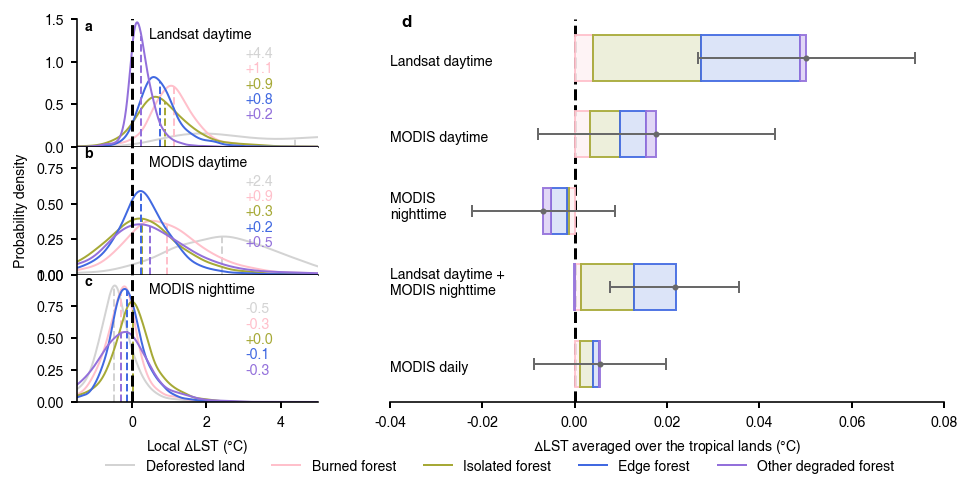

In [18]:
xtitle = 0.05
ytitle = 0.82
plt.rcParams['xtick.direction'] = 'out'
lc2 = [
    'Deforested\nland', 'Burned\nforest', 'Isolated\nforest', 'Edge\nforest'
]#2 rows
lc1 = [
    'Deforested land','Burned forest',  'Isolated forest', 'Edge forest','Other degraded forest'
]#1 row
color3 = ['lightgrey', 'pink', '#a6a936','royalblue','mediumpurple'] #non isolated burned edge other interior
color3_02 = ['#fef2f4','#ebeed7','#d9e1f8','#ded3f5']

smydiff_yr = np.stack((landsat_day_yr,modis_day_yr,modis_night_yr))

cm = 1/2.54
fig = plt.figure(figsize=(18*cm, 9*cm))  #width, height default(8,6)
font = {
    'family': 'sans-serif',
    'sans-serif': 'Helvetica',
    'weight': 'normal',
    'size': 7
}
plt.rc('font', **font)
fig.subplots_adjust(wspace=0.3,
                    hspace=0,
                    right=0.95,
                    left=0.1,
                    bottom=0.2,
                    top=0.95)
gs = GridSpec(3,3)
ylim = [0.6,0.55,0.9]
ylim = [1.5,0.9,1]
data_type1 = ['Landsat daytime','MODIS daytime','MODIS nighttime']
data_type = ['Landsat daytime','MODIS daytime','MODIS\nnighttime','Landsat daytime +\nMODIS nighttime','MODIS daily']
#--------------------------------------------------------------------------------------------------------
for ii in range(3):
    kde_ax = fig.add_subplot(gs[ii,0])
    kde_ax.set_title(fig_title[ii],weight=1000,fontsize=7, x=xtitle, y=ytitle)
    x0 = np.arange(-1.5,6,0.01)
    data = smydiff_yr[ii]
    smy_lc = np.copy(smy[:5])# 1+4 degraded forest
    smy_lc[np.isnan(data)]=np.nan
    for i in range(5):
        mean = nanaverage(data[i, :, :],weights=smy_lc[i])
        kenal1 = gaussian_kde(gc.nanravel(data[i, :, :]),weights=gc.nanravel(smy_lc[i]))
        z = kenal1.evaluate(x0)
        z_mean = kenal1.evaluate(mean)
        kde_ax.plot(x0,z,lw=1,color=color3[i],label=lc1[i])
        kde_ax.plot([mean,mean],[0,z_mean],lw=1,ls = '--',color=color3[i])
        if ii<2:
            kde_ax.text(0.7,0.7-i*0.12, '{:+.1f}'.format(mean),color=color3[i],transform = kde_ax.transAxes)
        else:
            kde_ax.text(0.7,0.7-i*0.12, '{:+.1f}'.format(mean),color=color3[i],transform = kde_ax.transAxes)
    kde_ax.plot([0, 0], [0, 2.5], ls='--', c='black')
    kde_ax.spines['right'].set_visible(False)
    kde_ax.spines['top'].set_visible(False)
    kde_ax.set_xlabel(r'Local $\Delta$LST (°C)')
    if ii==1:
        kde_ax.set_ylabel('Probability density')
    kde_ax.set_xlim(-1.5, 5)
    kde_ax.set_xticks([0,2,4])
    kde_ax.set_xticklabels([0,2,4])
    kde_ax.set_ylim(0, ylim[ii])
    kde_ax.text(0.3,0.85, data_type1[ii],transform = kde_ax.transAxes)
    if ii==2:
        kde_ax.legend(loc=(0.1,-0.6),frameon=False,ncol=5)
    kde_ax.tick_params(direction='out',width=1,length=3)
#--------------------------------------------------------------------------------------------------------
bar_ax  = fig.add_subplot(gs[:,1:])
data_type_x = [-0.04,-0.04,-0.04,-0.04,-0.04]
for i in range(5):
    for j in range(4):
        bar_ax.barh(5-i,smy_flux[j,i],height=0.6,left=cum_dp[j,i],fc=color3_02[j],alpha=0.9,edgecolor=color3[j+1],linewidth=1,zorder=30,label = lc1[j+1])
    bar_ax.errorbar(np.sum(smy_flux[:,i]),5-i,marker = 'o',markersize=2, xerr = smy_flux_error_all[i],color='dimgrey', ecolor='dimgrey',elinewidth=1,capsize=3,capthick=1,zorder=50)
    bar_ax.text(data_type_x[i],5-i-0.1, data_type[i])
    bar_ax.set_yticklabels([])
    bar_ax.set_yticks([])
bar_ax.spines['right'].set_visible(False)
bar_ax.spines['top'].set_visible(False)
bar_ax.spines['left'].set_visible(False)
bar_ax.axvline(x=0,ls='--', c='black')
bar_ax.set_xlabel('$\Delta$LST averaged over the tropical lands (°C)')
bar_ax.set_xlim(-0.04,0.08)
bar_ax.set_ylim(0.5,5.5)
bar_ax.set_title(fig_title[3],weight=1000, x=0.03, y=0.95)
bar_ax.tick_params(direction='out',width=1,length=3)
#fig.savefig(pathpic + PID + '_fig02.pdf', dpi=600)

# Fig3

In [26]:
PID11 = 'py11a'
smy = np.load(pathin +'smy_lc.npy')
#6,720,1440  1 non-forest +5 forest area: Burned forest, Isolated forest, Edge forest, Other degraded forest, Interior forest
smy = smy[1:5]*gc.globalarea(0.25)*100#100 km2=>ha
carbon_deficit = np.zeros((3,4))# 3 Tropical America, Tropical AFrica, Tropical Aisa; 4 degradations
carbon_deficit_sd = np.zeros((3,4))#  3 Tropical America, Tropical AFrica, Tropical Aisa; 4 degradations
smy_carbon_deficit = np.load(pathin+'smy_carbon_deficit.npy')
carbon_deficit_density = np.load(pathin+'carbon_deficit_density.npy')
region = np.array([[0,600],[600,960],[960,1440]])
for j in range(3):# 3 regions
    carbon_deficit[j] = np.nansum(smy_carbon_deficit[0,1:5,266:454, region[j,0]:region[j,1]]/10**9,(1,2))
    carbon_deficit_sd[j] = np.nansum(smy_carbon_deficit[1,1:5,266:454, region[j,0]:region[j,1]]/10**9,(1,2))
carbon_deficit_all = carbon_deficit #(3,4)3 regions 4 degradations
carbon_deficit_sd_all = np.zeros((3)) # 3 region
for i in range(3):
    carbon_deficit_sd_all[i] = np.sqrt(np.sum(carbon_deficit_sd[i,:]**2)) # 3 regions
#----------------------------------------------
smy[np.isnan(carbon_deficit_density)]=np.nan

27.44482999121355
20.740367520021007
25.100334108565225
4.091291389598221


Text(0, 0.5, 'AGC deficit (PgC)')

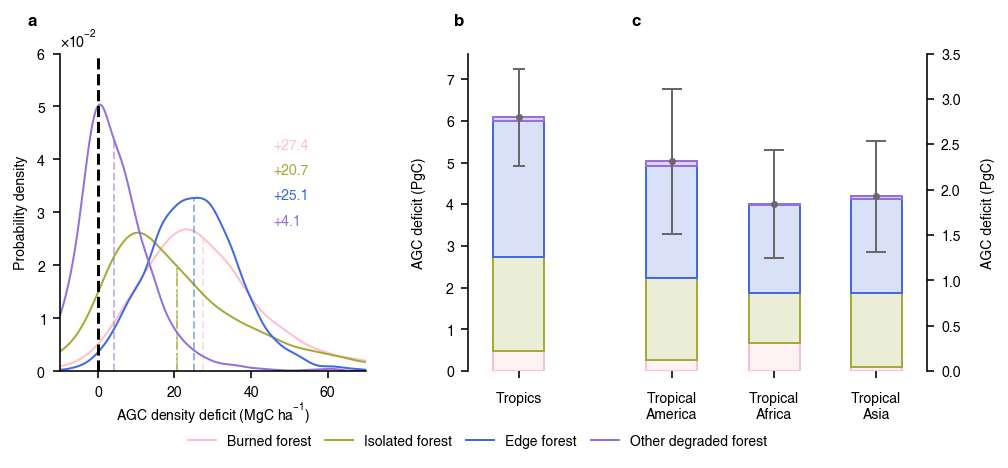

In [27]:
smy_mean = np.zeros((2,4))
lc = [ 'Burned forest','Isolated forest', 'Edge forest','Other degraded forest']
color = ['pink', '#a6a936', 'royalblue','mediumpurple'] 
color3_02 = ['#fef2f4','#ebeed7','#d9e1f8','#ded3f5']
lb_region = ['Tropical\nAmerica','Tropical\nAfrica','Tropical\nAsia']
capsize = 3
cm = 1/2.54
fig = plt.figure(figsize=(18*cm, 8*cm))  #width, height default(8,6)
font = {
    'family': 'sans-serif',
    'sans-serif': 'Helvetica',
    'weight': 'normal',
    'size': 7
}
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rc('font', **font)
kde_ax = fig.add_axes([0.07, 0.2, 0.3, 0.7])#left, bottom width, height
kde_ax.ticklabel_format(useMathText=True, scilimits=(-1,2), axis='y')
kde_ax.set_title('a',weight=1000, x=-0.09, y=1.05)
x0 = np.arange(-10,70,0.2)
ymax = [0.023,0.018,0.039]
lw =1
for i in range(4):
    kenal1 = gaussian_kde(gc.nanravel(carbon_deficit_density[i,:, :]),weights=gc.nanravel(smy[i]))#加权重#
    z = kenal1.evaluate(x0)
    kde_ax.plot(x0,z,lw=lw,color=color[i], label = lc[i])
    mean = np.average(gc.nanravel(carbon_deficit_density[i, :, :]),weights=gc.nanravel(smy[i]))
    std = w_std_1d(gc.nanravel(carbon_deficit_density[i, :, :]),w=gc.nanravel(smy[i]))
    print(mean)
    y_mean = kenal1.evaluate(mean)
    kde_ax.plot([mean,mean],[0,y_mean], ls='--',c=color[i],lw=lw,alpha=0.5)
    kde_ax.text(0.7,0.7-i*0.08, '{:+.1f}'.format(mean),color=color[i],transform = kde_ax.transAxes)
    if i==1:
        kde_ax.plot([mean,mean],[0,y_mean], ls='-.',c=color[i],lw=lw,alpha=0.5)
    smy_mean[0,i] = mean
    smy_mean[1,i] = std
kde_ax.plot([0, 0], [0, 1.5], ls='--', c='black')
kde_ax.spines['right'].set_visible(False)
kde_ax.spines['top'].set_visible(False)
kde_ax.legend(loc=(0.4, -0.26), frameon=False, ncol=4,columnspacing=1)
kde_ax.set_xlabel('AGC density deficit (MgC $\mathregular{ha^{-1}}$)',labelpad=1)
kde_ax.set_ylabel('Probability density')
kde_ax.set_xlim(-10, 70)
kde_ax.set_ylim(0, 0.06)
#----------------------------------------------------------------------
bar_ax = fig.add_axes([0.62, 0.2, 0.3, 0.7])#left, bottom width, height
bar_ax.yaxis.tick_right()
bar_ax.yaxis.set_label_position("right")
bar_ax.set_title('c',weight=1000, x=0.05, y=1.05)
for iregion in range(3):
    for i in range(4):#degradation
        bar_ax.bar(2+iregion*2,carbon_deficit_all[iregion,i],width=1,bottom = np.sum(carbon_deficit_all[iregion,:i]),fc=color3_02[i], alpha=1,edgecolor=color[i],linewidth=1,zorder=30,label = lc[i])
    bar_ax.errorbar(y=np.sum(carbon_deficit_all[iregion,:]),x=2+iregion*2,marker='o',markersize=2.5,yerr =carbon_deficit_sd_all[iregion],color='dimgrey', ecolor='dimgrey',capsize=5,elinewidth=1,capthick=1,zorder=50)
    bar_ax.spines['left'].set_visible(False)
    bar_ax.spines['top'].set_visible(False)
    bar_ax.spines['bottom'].set_visible(False)
    bar_ax.set_xticks([2,4,6])
    bar_ax.set_xticklabels(lb_region,y=-0.02,rotation=0)
    bar_ax.set_ylabel('AGC deficit (PgC)',labelpad=10)
bar_ax.set_xlim(1,7)
bar_ax.set_ylim(0,3.5)
#----------------------------------------------------------------------
bar_ax2 = fig.add_axes([0.47, 0.2, 0.1, 0.7])#left, bottom width, height
bar_ax2.set_title('b',weight=1000, x=-0.09, y=1.05)
for i in range(4):#degradation
    bar_ax2.bar(1,np.sum(carbon_deficit_all[:,i],0),width=1,bottom = np.sum(carbon_deficit_all[:,:i]),fc=color3_02[i], alpha=1,edgecolor=color[i],linewidth=1,zorder=30,label = lc[i])
bar_ax2.errorbar(y=np.sum(carbon_deficit_all[:,:]),x=1,marker='o',markersize=2.5,yerr =np.sqrt(np.sum(carbon_deficit_sd_all[:]**2)),color='dimgrey', ecolor='dimgrey',capsize=3,elinewidth=1,capthick=1,zorder=50)
bar_ax2.spines['right'].set_visible(False)
bar_ax2.spines['top'].set_visible(False)
bar_ax2.spines['bottom'].set_visible(False)
bar_ax2.set_xticks([1])
bar_ax2.set_xlim(0,2)
bar_ax2.set_xticklabels(['Tropics'],y=-0.02,rotation=0)
bar_ax2.set_ylabel('AGC deficit (PgC)',labelpad=10)
#fig.savefig(pathpic + PID + '_fig03.pdf', dpi=600)

# Fig4

In [31]:
smy_lc_no = np.load(pathin+'smy_lc_no.npy')
smy_area = np.zeros((2,2))# 2 ant nat 2 lc iso edge 
smy_area[0,0] = np.nansum(smy_lc_no[0]*area)# ant iso
smy_area[1,0] = np.nansum(smy_lc_no[1]*area)## nat iso
smy_area[0,1] = np.nansum(smy_lc_no[2]*area)## ant edge
smy_area[1,1] = np.nansum(smy_lc_no[3]*area)## nat edge
smy_area = smy_area[::-1,:]
smy_area = smy_area/10**6
#------LST--------
smy_flux_ori = np.load(pathin + 'smy_flux_ori.npy')[0,0,2:4]# iso edge 
mean_lst_yr  = np.load(pathin + 'mean_lst_yr.npy')[0]#3 mean, std,p; 2 no; 2 lc
mean_lst_yr = np.sum(mean_lst_yr,0)# 2 lc
lst_scale = smy_flux_ori[:]/mean_lst_yr[:] # 2 lc
mean_lst_yr0 = np.load(pathin + 'mean_lst_yr.npy')# #3 mean, std,p; 2 no; 2 lc
mean_lst_yr1 = np.zeros((2,2,3))
lst_diff = np.zeros((2,2))
lst_diff_sd = np.zeros((2,2))
for ino in range(2):
    for ilc in range(2):
        lst_diff[ino,ilc] = mean_lst_yr0[0,ino,ilc]*lst_scale[ilc]
        lst_diff_sd[ino,ilc] = mean_lst_yr0[1,ino,ilc]*lst_scale[ilc]
        #print('ino{} ilc{} lst{:.3f} lst_scale{:.2f}'.format(ino,ilc,mean_lst_yr0[0,ino,ilc],lst_scale[ilc]))
lst_diff = lst_diff[::-1,:]#2 old new ; 2 degradations
lst_diff_sd = lst_diff_sd[::-1,:]
#-------carbon-------
smy_carbon_deficit = np.load(pathin+'smy_carbon_deficit_no.npy')
carbon_deficit = np.nansum(smy_carbon_deficit[0]/10**9,(2,3))
carbon_deficit_sd = np.nansum(smy_carbon_deficit[1]/10**9,(2,3))
carbon_deficit = carbon_deficit[::-1,:]
carbon_deficit_sd = carbon_deficit_sd[::-1,:]

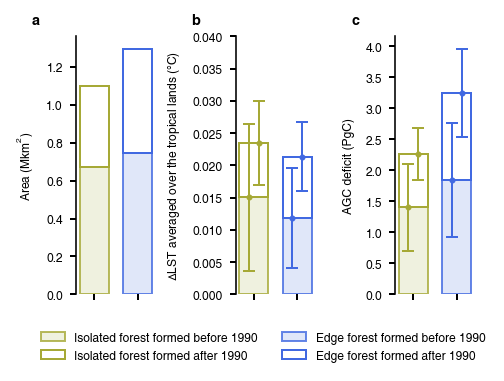

In [33]:
plt.rcParams["mathtext.default"]="regular"
from matplotlib import mathtext
mathtext.FontConstantsBase.sup1 = 0.45
from scipy.stats import gaussian_kde
lc_new = ['Isolated forest formed after 1990',  'Edge forest formed after 1990']
lc_old = ['Isolated forest formed before 1990',  'Edge forest formed before 1990']

lc2 = [
    'Open\nland', 'Isolated\nforest', 'Burned\nforest', 'Edge\nforest'
]#2 rows
color = ['#a6a936', 'royalblue','mediumpurple'] #non isolated burned edge interior
color3_02 = ['#ebeed7','#d9e1f8','#ded3f5']
lc_tpye = ['Old','New','New to old']
capsize = 3
lw=3
cm = 1/2.54
fig = plt.figure(figsize=(8.8*cm, 7*cm))  #width, height default(8,6)
font = {
    'family': 'sans-serif',
    'sans-serif': 'Helvetica',
    'weight': 'normal',
    'size': 6
}
ytitle=1
xtitle=-0.5
plt.rc('font', **font)
fig.subplots_adjust(wspace=1,
                    hspace=0.15,
                    right=0.95,
                    left=0.15,
                    bottom=0.25,
                    top=0.9)
plt.rcParams['xtick.direction'] = 'out'
#######################################################################
#-----------------ac-------------------
#########################################################################
#----------area----------
bar_ax = fig.add_subplot(1,3,1)
bar_width = 0.6
set_ms = 2 # markersize
for i in range(2):#degradation
    bar_ax.bar(i*0.9+1,smy_area[0,i],width=bar_width,fc=color3_02[i], alpha=0.8,edgecolor=color[i],linewidth=1,zorder=30,label = lc_tpye[0])#,hatch='/'
    bar_ax.bar(i*0.9+1,smy_area[1,i],width=bar_width,bottom = smy_area[0,i],fc='white', alpha=1,edgecolor=color[i],linewidth=1,zorder=30,label = lc_tpye[1])
bar_ax.spines['right'].set_visible(False)
bar_ax.spines['top'].set_visible(False)
bar_ax.spines['bottom'].set_visible(False)
bar_ax.set_xticks([1,1.9])
bar_ax.set_xticklabels([])
bar_ax.set_ylabel('Area (Mkm$^2$)',labelpad=5)
bar_ax.set_title('a',weight=1000, x=xtitle, y=ytitle)
bar_ax.tick_params(direction='out',width=1,length=3)
#-------------------------------------BGP----------------------------------------------------
bar_ax = fig.add_subplot(1,3,2)
for i in range(2):#degradation
    bar_ax.bar(i*0.9+1,lst_diff[0,i],width=bar_width,fc=color3_02[i], alpha=0.8,edgecolor=color[i],linewidth=1,zorder=30,label = lc_tpye[0])#,hatch='/'
    bar_ax.bar(i*0.9+1,lst_diff[1,i],width=bar_width,bottom = lst_diff[0,i],fc='white', alpha=1,edgecolor=color[i],linewidth=1,zorder=30,label = lc_tpye[1])
    bar_ax.errorbar(y=lst_diff[0,i],x=i*0.9+0.9,yerr =lst_diff_sd[0,i],color=color[i],marker = 'o',markersize=set_ms, ecolor=color[i],capsize=3,elinewidth=1,capthick=1,zorder=50)
    bar_ax.errorbar(y=lst_diff[0,i]+lst_diff[1,i],x=i*0.9+1.1,yerr =lst_diff_sd[1,i],color=color[i], marker = 'o',markersize=set_ms,ecolor=color[i],capsize=3,elinewidth=1,capthick=1,zorder=50)
bar_ax.spines['right'].set_visible(False)
bar_ax.spines['top'].set_visible(False)
bar_ax.spines['bottom'].set_visible(False)
bar_ax.set_xticks([1,1.9])
bar_ax.set_xticklabels([])
bar_ax.set_ylabel('$\Delta$LST averaged over the tropical lands (°C)',labelpad=5)
bar_ax.set_title('b',weight=1000, x=xtitle, y=ytitle)
bar_ax.set_ylim(0,0.04)
bar_ax.tick_params(direction='out',width=1,length=3)
#-------------------------------------BGC-----------------------------------------------------
bar_ax = fig.add_subplot(1,3,3)
for i in range(2):#degradation
    bar_ax.bar(i*0.9+1,carbon_deficit[0,i],width=bar_width,fc=color3_02[i], alpha=0.8,edgecolor=color[i],linewidth=1,zorder=30,label = lc_old[i])#,hatch='/'
    bar_ax.bar(i*0.9+1,carbon_deficit[1,i],width=bar_width,bottom = carbon_deficit[0,i],fc='white', alpha=1,edgecolor=color[i],linewidth=1,zorder=30,label = lc_new[i])
    bar_ax.errorbar(y=carbon_deficit[0,i],x=i*0.9+0.9,yerr =carbon_deficit_sd[0,i],color=color[i],marker = 'o',markersize=set_ms, ecolor=color[i],capsize=3,elinewidth=1,capthick=1,zorder=50)
    bar_ax.errorbar(y=carbon_deficit[0,i]+carbon_deficit[1,i],x=i*0.9+1.1,yerr =carbon_deficit_sd[1,i],color=color[i],marker = 'o',markersize=set_ms, ecolor=color[i],capsize=3,elinewidth=1,capthick=1,zorder=50)
bar_ax.legend(loc=(-4.5,-0.28),frameon=False,ncol=2)#
bar_ax.spines['right'].set_visible(False)
bar_ax.spines['top'].set_visible(False)
bar_ax.spines['bottom'].set_visible(False)
bar_ax.set_xticks([1,1.9])
bar_ax.set_xticklabels([])
bar_ax.set_ylabel('AGC deficit (PgC)',labelpad=5)
bar_ax.set_title('c',weight=1000, x=xtitle, y=ytitle)
bar_ax.tick_params(direction='out',width=1,length=3)
#fig.savefig(pathout_fig + PID+'_fig04.pdf', dpi=600)